In [1]:
import torch
import torch.nn.functional as F
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from torch.utils.data import Dataset, DataLoader,random_split
import torch.optim as optim
from tqdm import tqdm
import h5py
import scipy
from scipy.signal import find_peaks
from IPython.display import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import utils
import Model
import Simulate_Dataset


torch.autograd.set_detect_anomaly(True)
# Set a random seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

x_const = None
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
class load_dataset(Dataset):
    def __init__(self, path,device):
        data = scipy.io.loadmat(path)['imagingData']['samples'][0,0]
        self.y = torch.tensor(data)
        self.y = self.y.transpose(1, 2)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.y[idx]


def load_behave_data(path, metrics = ['lift','grab','atmouth','supination'],cutoff = 0):
    data = scipy.io.loadmat(path)['BehaveData']
    field_names = data.dtype.names
    behavior_dict = {}
    for metric in metrics:
      behave = None
      for field in field_names:
        if metric in field:
          events = np.concatenate(scipy.io.loadmat(path)['BehaveData'][field][0][0][0][0][0][:,cutoff:])
          if behave is None:
            behave = np.zeros((len(events),))
          behave += events
      behavior_dict[metric] = behave > 0 #there is event overlap

    return behavior_dict


# create dataset
print("Creating signal dataset")
dataset = load_dataset(r'./data.mat',device = device)

metrics = ['lift','grab','supination','atmouth']
print("Creating behave dataset")
dataset_behave = load_behave_data(r'./data.mat',metrics=metrics)

Creating signal dataset
Creating behave dataset


In [3]:
class Test(torch.nn.Module):
    def __init__(self, hyp, H=None):
        super(Test, self).__init__()

        self.T = hyp["T"]  # number of encoder unfolding
        self.L = hyp["L"]  # 1/L is the step size in the encoder
        self.C = hyp["C"]  # number of filters
        self.K = hyp["K"]  # legnth of the filters
        self.lam = hyp["lam"]  # lambda (regularization parameter)
        self.device = hyp["device"]  # device (i.e., cpu, cuda0)

        # initialize the filter H
        if H is None:
            # initialize with random normal
            H = torch.randn((self.C, 1, self.K), device=self.device)
            # normalize that each filter has norm 1
            H = F.normalize(H, p=2, dim=-1)
        # register the filters as weights of
        # the neural network so that to be trainable.
        self.register_parameter("H", torch.nn.Parameter(H))
        # create ReLU
        self.relu = torch.nn.ReLU()

    def get_param(self, name):
        # get parameters with name
        return self.state_dict(keep_vars=True)[name]

    def normalize(self):
        # normalize the filters
        self.get_param("H").data = F.normalize(self.get_param("H").data, p=2, dim=-1)

    def H_operator(self, x):
        return F.conv_transpose1d(x, self.get_param("H"))

    def HT_operator(self, x):
        return F.conv1d(x, self.get_param("H"))

    def encoder(self, y):
        enc_dim = F.conv1d(y[0,0].unsqueeze(0).float(), self.get_param("H")).shape[-1]
        x_old = torch.zeros(y.shape[0], self.C*y.shape[1], enc_dim, device=self.device)
        x_tmp = torch.zeros(y.shape[0],self.C*y.shape[1], enc_dim, device=self.device)
        x_new = torch.zeros(y.shape[0],self.C*y.shape[1], enc_dim, device=self.device)
        print(x_new.size())
        s_old = torch.ones_like(y[0, :, 0], device=self.device)

        # T recurrent steps
        for t in range(self.T):
            for row in range(y.shape[1]):
                res = (y[:,row,:].unsqueeze(1) - self.H_operator(x_tmp[:,row*self.C:(row+1)*(self.C),:])).float()
                x_new[:,row*self.C:(row+1)*(self.C),:] = x_tmp[:,row*self.C:(row+1)*(self.C),:] + self.HT_operator(res) / self.L
                x_new[:,row*self.C:(row+1)*(self.C),:] = self.relu(x_new[:,row*self.C:(row+1)*(self.C),:] - self.lam / self.L)
                s_new = (1 + torch.sqrt(1 + 4 * s_old[row] * s_old[row])) / 2
                x_tmp[:,row*self.C:(row+1)*(self.C),:] = x_new[:,row*self.C:(row+1)*(self.C),:] + (s_old[row] - 1) / s_new * (x_new[:,row*self.C:(row+1)*(self.C),:] - x_old[:,row*self.C:(row+1)*(self.C),:])
                x_old[:,row*self.C:(row+1)*(self.C),:] = x_new[:,row*self.C:(row+1)*(self.C),:]
                s_old[row] = s_new
        return x_new

    def decoder(self, x):
        decoder_dim = F.conv_transpose1d(x[:,:self.C, :],self.get_param("H")).size(-1)
        result = torch.zeros(x.shape[0],x.shape[1] ,decoder_dim, device=self.device)
        for row in range(x.shape[1]):
            conv_result = F.conv_transpose1d(
                x[:, row * self.C : (row + 1) * self.C, :],
                self.get_param("H")
            )
            result[:,row,:] = conv_result.squeeze(1)
    
        # Stack the results along the new dimension (dim=1) to form the final tensor
        print(result.size())
        return result
        
    def forward(self, y):
        # encoder
        x = self.encoder(y)
        # decoder
        y_hat = self.decoder(x)
        return y_hat, x


In [4]:
net_hyp = {"T": 200,                 # number of encoder unfolding
           "L": 10,                  # 1/L is the step size in the encoder
           "C": 1,                 # number of filters
           "K": 7,                  # legnth of the filters
           "lam": 0.2,
           "device": device
           }

net = Test(net_hyp)

# training parameters
train_hyp = {"batch_size": 87, "num_epochs": 3, "lr": 1e-2, "shuffle": False}
# data loader
train_loader = DataLoader(dataset, shuffle=train_hyp["shuffle"], batch_size=train_hyp["batch_size"])
# criterion
criterion = torch.nn.MSELoss()
# optimizer
optimizer = optim.Adam(net.parameters(), lr=train_hyp["lr"], eps=1e-3)

In [5]:
for epoch in tqdm(range(train_hyp["num_epochs"]), disable=True):
    loss_all = 0
    for idx, y in tqdm(enumerate(train_loader), disable=False):
        y = y.to(device)

        # run the network in forward net(y) to get y_hat and x_hat
        y_hat, _= net(y)

        # compute loss using the created criterion
        loss = criterion(y.float(), y_hat.float())
        loss_all += float(loss.item())

        # set the gradients in the optimizer to zero (optimizer.zero_grad())
        optimizer.zero_grad()
        # do backward on the loss
        loss.backward()
        # take a step with the optimizer
        optimizer.step()

        # normalize filters
        net.normalize()

        #err_h = compute_err_h(dataset.H, net.get_param("H"))
    print("Epoch [{}/{}]loss:{:.4f}\n".format(epoch+1,train_hyp["num_epochs"],loss_all))

0it [00:00, ?it/s]

torch.Size([63, 87, 236])
torch.Size([63, 87, 242])


C:\Users\yonatan.kle\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\__init__.py:200: UserWarning: Error detected in ConvolutionBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\yonatan.kle\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\yonatan.kle\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
    app.start()
  File "C:\Users\yonatan.kle\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "C:\Users\yonatan.kle\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\yonatan.

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [63, 1, 236]], which is output 0 of AsStridedBackward0, is at version 17400; expected version 17399 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

21048


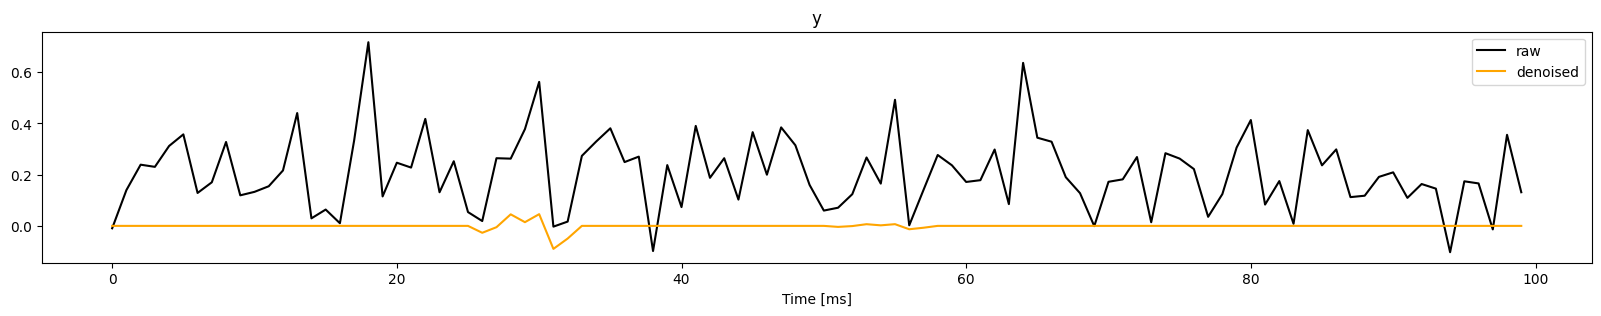

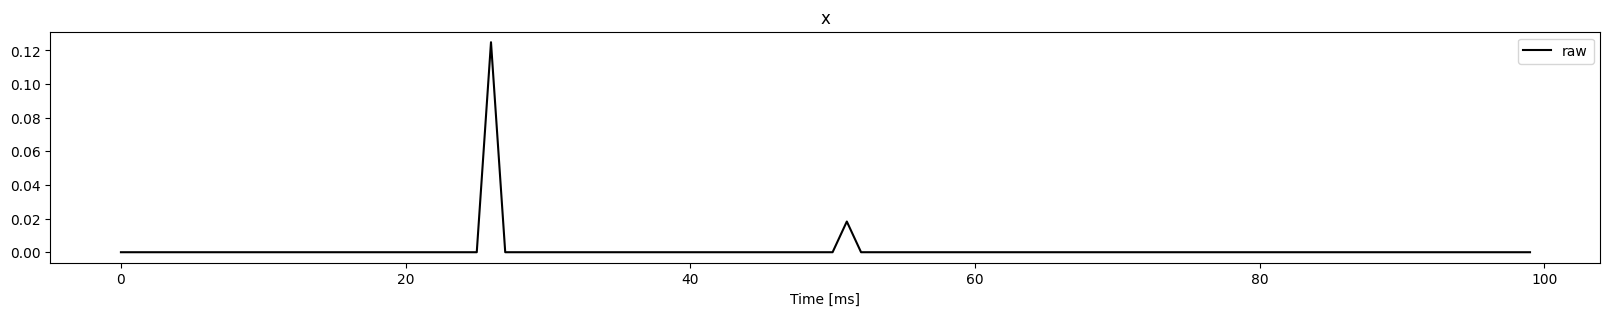

In [86]:
yi = dataset[0:3]
yi_hat, xi_hat = net(yi)

# visualize the data
utils.vis_data_est(yi[1,0][0:100], yi_hat[1,0][0:100])

# visualize Hx1 and Hx2
utils.vis_data(xi_hat[1,0][0:100])


torch.Size([63, 1, 2996])
torch.Size([63, 1, 3024])
torch.Size([3024])


C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_16656\1756469396.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])


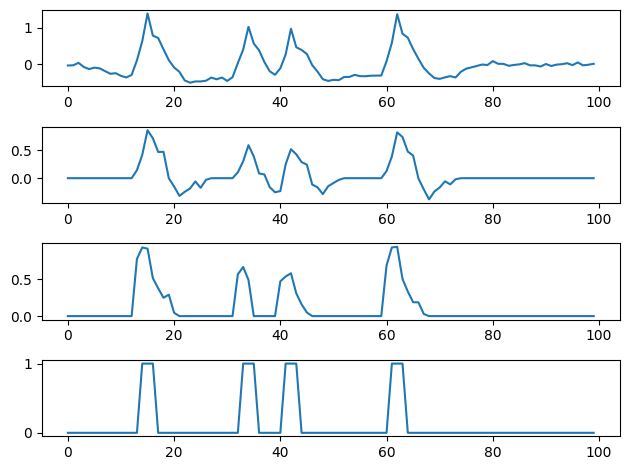

In [66]:
with torch.no_grad():
    y,x,_,_ = dataset[:]
    print(x.size())
    x = torch.sum(x, dim=1, keepdim=True)
    y_hat, x_hat = net(y)
    print(x_hat.size())
    x_hat = torch.sum(x_hat, dim=1, keepdim=True)
    b = x[0,0] > 0
    x = x.squeeze(dim = 1)
    #y_hat = y_hat.squeeze(dim = 1)
    x_hat = x_hat.squeeze(dim = 1)
    padding_begining = 14
    padding_end = 14
    # Perform the padding
    padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
    modified_tensor = torch.zeros_like(padded_tensor).to(device)
    indices_of_ones = torch.nonzero(padded_tensor).squeeze()
    for index in indices_of_ones:
        modified_tensor[index-1:index+2] = torch.tensor([1,1,1]).to(device)
    print(modified_tensor.size())


plt.figure()
# Create subplots
plt.subplot(4, 1, 1)
plt.plot(y[0,0][0:100].cpu(), label='ground truth')
plt.subplot(4, 1, 2)
plt.plot(y_hat[0,0][0:100].cpu(), label='predicted')
plt.subplot(4, 1, 3)
plt.plot(x_hat[0][0:100].cpu(), label='signal')
plt.subplot(4, 1, 4)
plt.plot(modified_tensor.cpu()[0:100], label='signal')
# Show or save the figure
plt.tight_layout()  # Adjust subplot spacing for clarity
plt.show()